In [118]:
import layoutparser as lp 

import matplotlib.pyplot as plt
%matplotlib inline 

import pandas as pd
import numpy as np
import cv2

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

In [120]:
#ocr_agent = lp.GCVAgent.with_credential("lp://PubLayNet/faster_rcnn_R_50_FPN_3x/config",
                                       #languages = ['en'])

In [121]:
ocr_agent = lp.GCVAgent.with_credential("/home/vimal/Documents/table_detect_samples/samples",
                                       languages = ['en'])

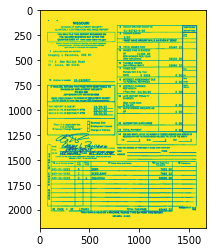

In [122]:
img = mpimg.imread('/home/vimal/Documents/table_detect_samples/samples/0154742000.jpeg')
plt.imshow(img)


In [123]:

#image = cv2.imread('data/example-table.jpeg')
#plt.imshow(image);

In [125]:
res = ocr_agent.detect(img, return_response=True)


AttributeError: 'GCVAgent' object has no attribute '_client'

In [3]:
import cv2

In [4]:
import layoutparser as lp

In [5]:
image = cv2.imread("/home/vimal/Documents/table_detect_samples/samples/0120452000.jpeg")
image = image[..., ::-1] 

In [6]:
model = lp.Detectron2LayoutModel('lp://PubLayNet/faster_rcnn_R_50_FPN_3x/config', 
                                 extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.8],
                                 label_map={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"})

In [7]:
layout = model.detect(image)


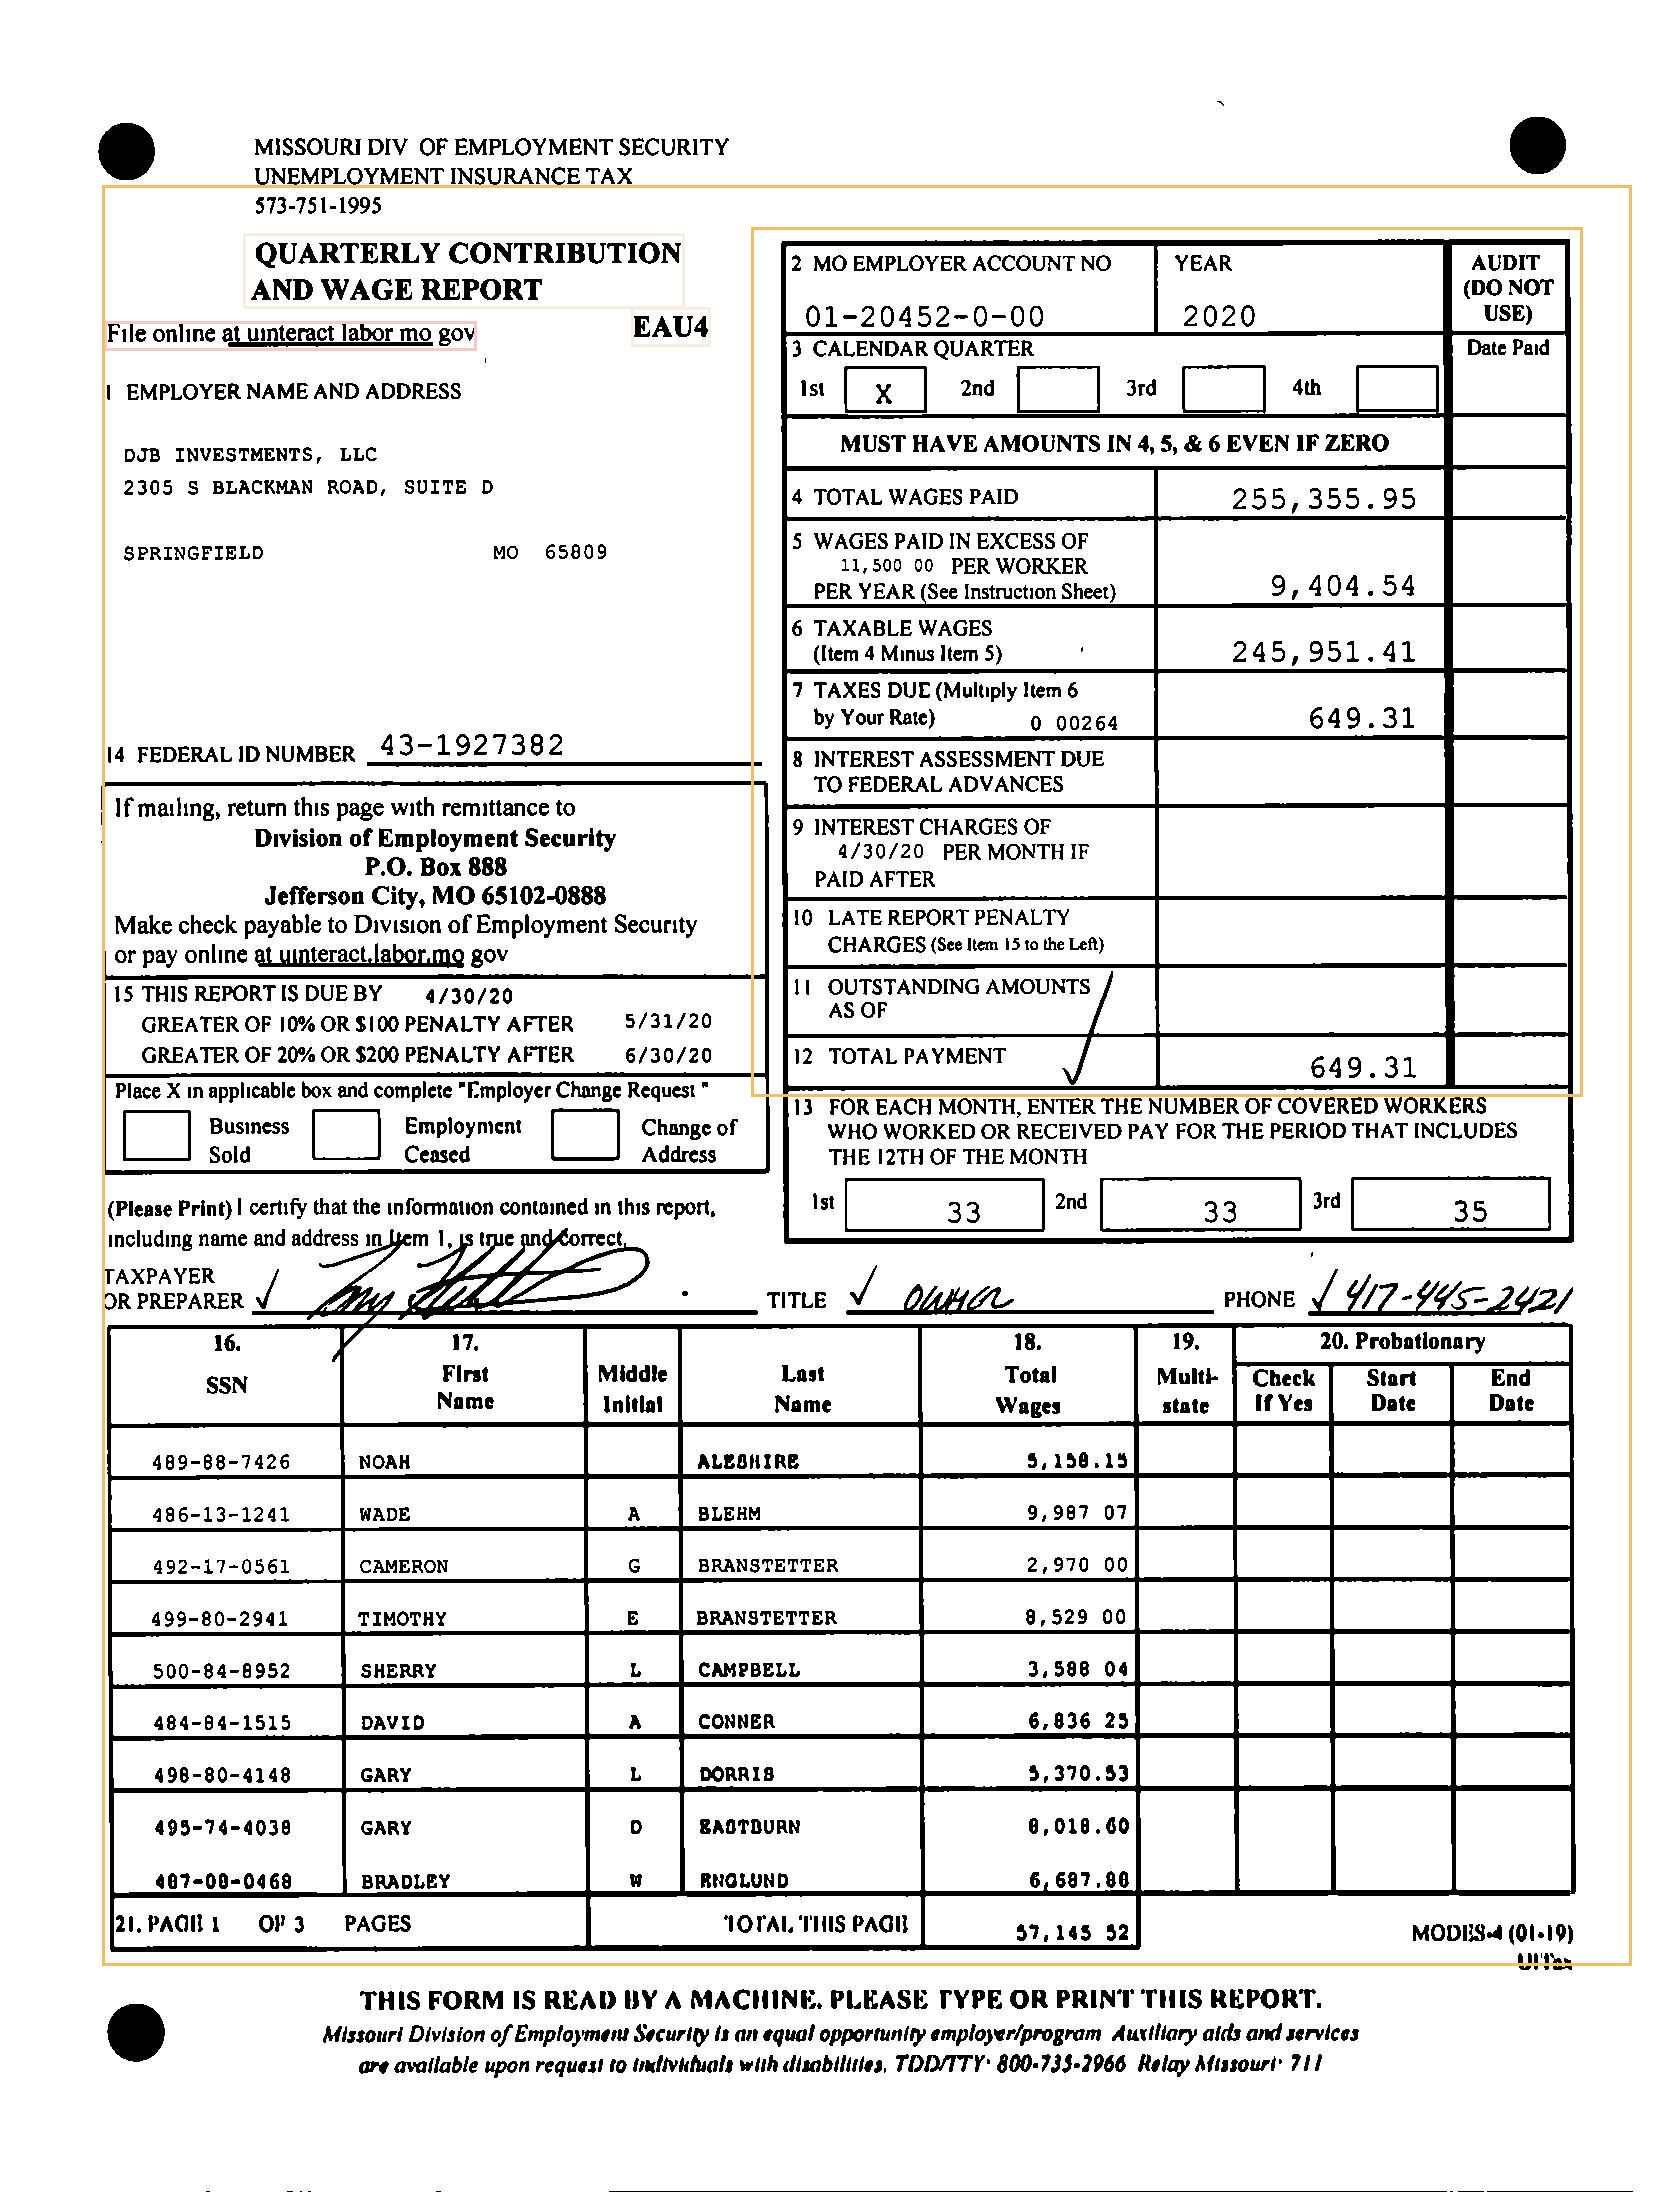

In [8]:
lp.draw_box(image, layout, box_width=3)


In [9]:
type(layout)


layoutparser.elements.Layout

In [10]:
layout[0]


TextBlock(block=Rectangle(x_1=104.84395599365234, y_1=321.1158447265625, x_2=476.4727783203125, y_2=350.8190002441406), text=None, id=None, type=Text, parent=None, next=None, score=0.9732474088668823)

In [11]:
text_blocks = lp.Layout([b for b in layout if b.type=='Text'])
figure_blocks = lp.Layout([b for b in layout if b.type=='Figure'])

In [12]:
text_blocks = lp.Layout([b for b in text_blocks \
                   if not any(b.is_in(b_fig) for b_fig in figure_blocks)])


In [13]:
h, w = image.shape[:2]

left_interval = lp.Interval(0, w/2*1.05, axis='x').put_on_canvas(image)

left_blocks = text_blocks.filter_by(left_interval, center=True)
left_blocks.sort(key = lambda b:b.coordinates[1])

right_blocks = [b for b in text_blocks if b not in left_blocks]
right_blocks.sort(key = lambda b:b.coordinates[1])

# And finally combine the two list and add the index
# according to the order
text_blocks = lp.Layout([b.set(id = idx) for idx, b in enumerate(left_blocks + right_blocks)])

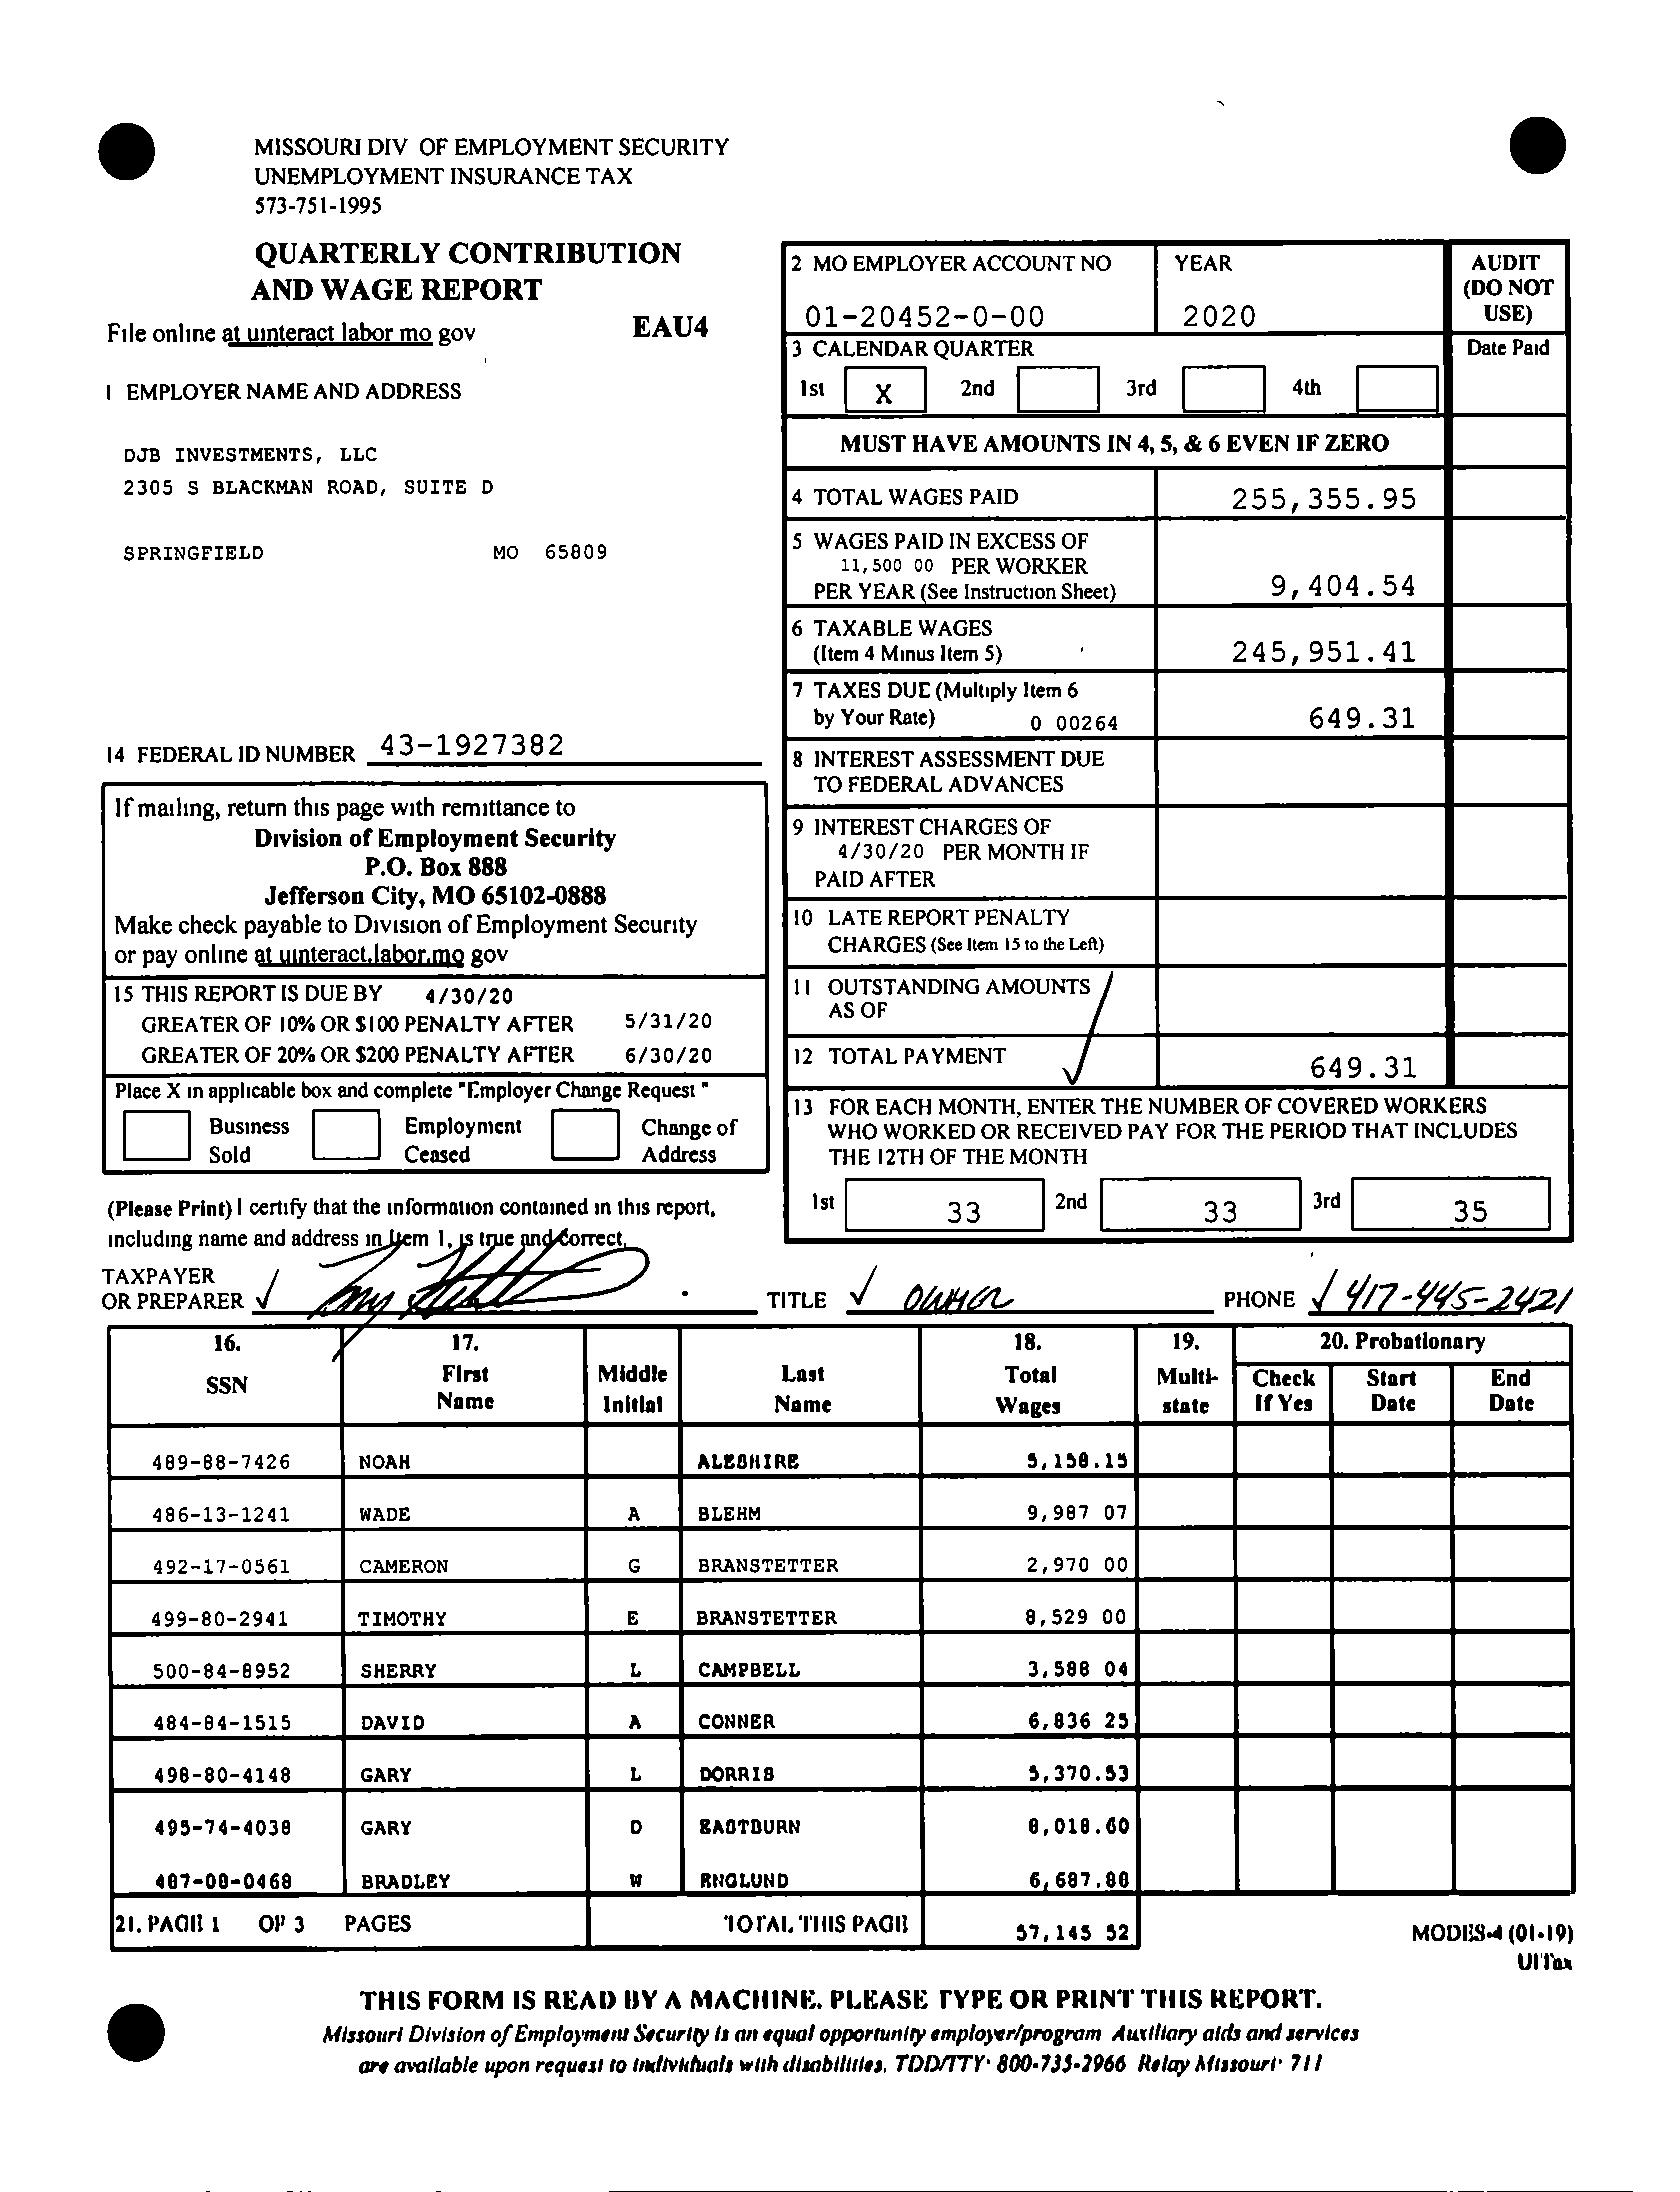

In [14]:
lp.draw_box(image, text_blocks,
            box_width=3, 
            show_element_id=True)

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv

In [2]:
try:
    from PIL import Image
except ImportError:
    import Image
import pytesseract

In [47]:
file=r'/home/vimal/Documents/table_detect_samples/samples/0782492000.jpeg'
img = cv2.imread(file,0)
img.shape

(2179, 1672)

In [48]:
img.size

3643288

In [49]:
thresh,img_bin = cv2.threshold(img,128,255,cv2.THRESH_BINARY |cv2.THRESH_OTSU)


In [50]:
img_bin = 255-img_bin
cv2.imwrite('/home/vimal/Documents/table_detect_samples/opt/0782492000_grey.jpeg',img_bin)


True

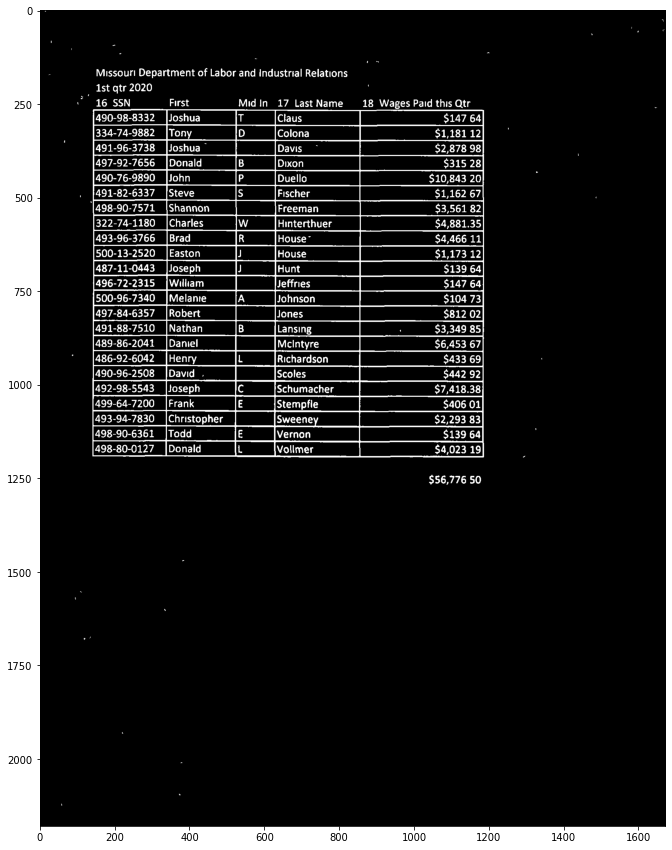

In [51]:
plt.figure(figsize=(15,15))
plotting = plt.imshow(img_bin,cmap='gray')
plt.show()

In [52]:
kernel_len = np.array(img).shape[1]//100


In [53]:
ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len))

In [54]:
hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len, 1))

In [55]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

In [56]:
kernel

array([[1, 1],
       [1, 1]], dtype=uint8)

In [57]:
image_1 = cv2.erode(img_bin, ver_kernel, iterations=3)
vertical_lines = cv2.dilate(image_1, ver_kernel, iterations=3)

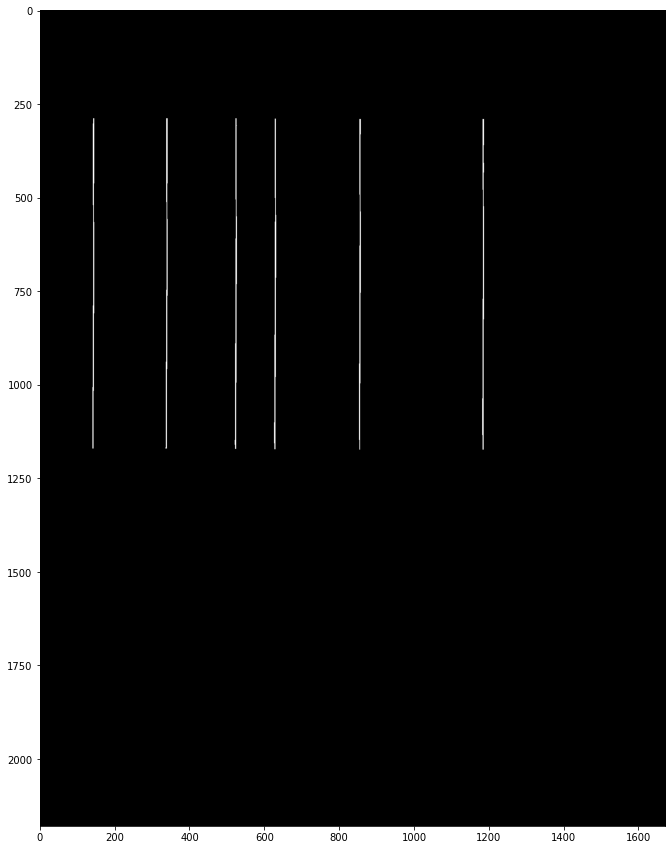

In [58]:
plt.figure(figsize=(15,15))

plotting = plt.imshow(image_1,cmap='gray')
plt.show()

In [59]:
image_2 = cv2.erode(img_bin, hor_kernel, iterations=3)
horizontal_lines = cv2.dilate(image_2, hor_kernel, iterations=3)

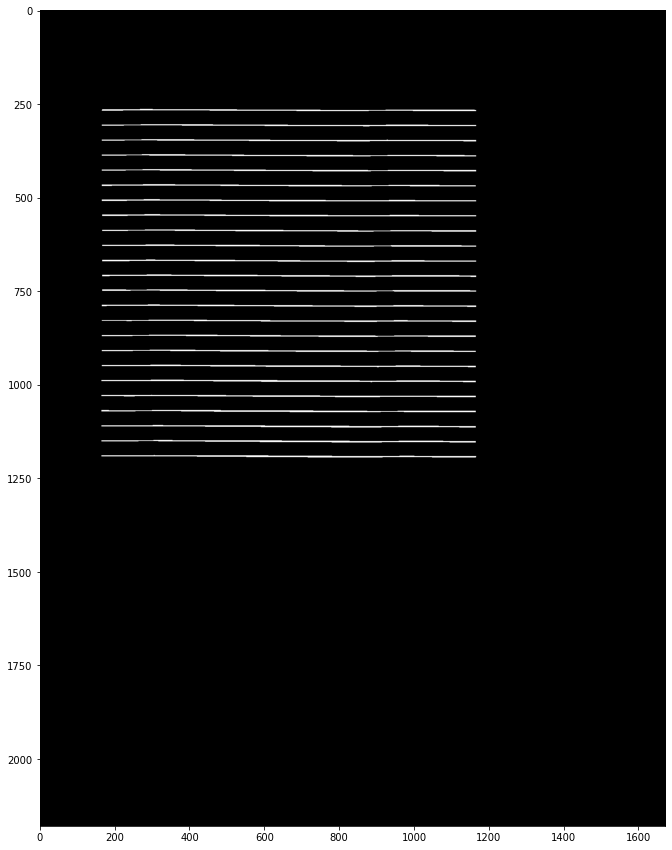

In [60]:
plt.figure(figsize=(15,15))
plotting = plt.imshow(image_2,cmap='gray')
plt.show()

In [61]:
img_vh = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)

In [62]:
img_vh = cv2.erode(~img_vh, kernel, iterations=2)
thresh, img_vh = cv2.threshold(img_vh,128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

In [63]:
cv2.imwrite("/home/vimal/Documents/table_detect_samples/opt/0782492000.jpeg", img_vh)


True

In [64]:
bitxor = cv2.bitwise_xor(img,img_vh)
bitnot = cv2.bitwise_not(bitxor)

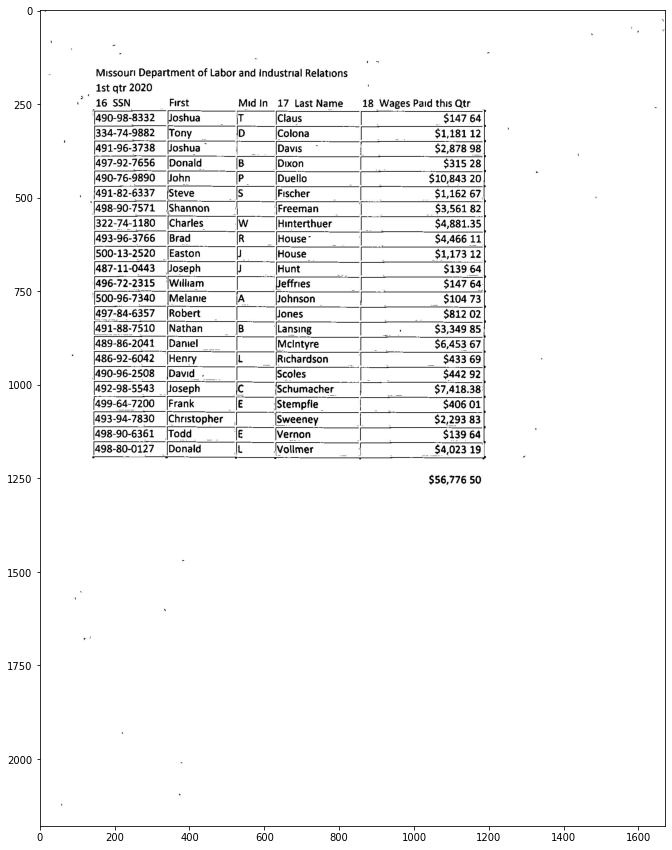

In [65]:
plt.figure(figsize=(15,15))

plotting = plt.imshow(bitnot,cmap='gray')
plt.show()

In [66]:
contours, hierarchy = cv2.findContours(img_vh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [67]:
def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0
    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)


In [68]:
contours, boundingBoxes = sort_contours(contours, method='top-to-bottom')

In [69]:
heights = [boundingBoxes[i][3] for i in range(len(boundingBoxes))]


In [70]:
mean = np.mean(heights)


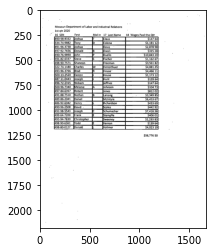

In [71]:
box = []
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    if (w<1000 and h<500):
        image = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
        box.append([x,y,w,h])
plotting = plt.imshow(image,cmap='gray')
plt.show()

In [72]:
row=[]
column=[]
j=0
for i in range(len(box)):
    if(i==0):
        column.append(box[i])
        previous=box[i]
    else:
        if(box[i][1]<=previous[1]+mean/2):
            column.append(box[i])
            previous=box[i]
            if(i==len(box)-1):
                row.append(column)
        else:
            row.append(column)
            column=[]
            previous = box[i]
            column.append(box[i])
print(column)
print(row)

[[145, 1153, 190, 36], [341, 1154, 180, 35], [526, 1155, 100, 34], [857, 1156, 325, 35], [631, 1156, 222, 35]]
[[[343, 270, 179, 36], [147, 270, 190, 36], [859, 271, 323, 36], [632, 271, 221, 36], [527, 271, 100, 35]], [[343, 310, 179, 36], [147, 310, 190, 36], [527, 311, 100, 35], [859, 312, 323, 35], [632, 312, 221, 35]], [[147, 350, 190, 36], [527, 351, 100, 36], [343, 351, 179, 35], [858, 352, 324, 36], [632, 352, 221, 35]], [[147, 390, 190, 36], [343, 391, 179, 35], [858, 392, 324, 36], [632, 392, 221, 35], [527, 392, 100, 34]], [[147, 430, 190, 36], [343, 431, 179, 35], [858, 432, 324, 36], [632, 432, 221, 36], [527, 432, 100, 35]], [[342, 471, 180, 36], [146, 471, 191, 35], [858, 472, 325, 36], [632, 472, 221, 36], [527, 472, 100, 35]], [[342, 511, 181, 36], [146, 511, 192, 35], [527, 512, 101, 35], [858, 513, 325, 35], [632, 513, 222, 35]], [[343, 551, 180, 36], [147, 551, 191, 36], [528, 552, 99, 35], [859, 553, 324, 36], [633, 553, 221, 35]], [[147, 591, 191, 36], [343, 592, 

In [73]:
countcol = 0
for i in range(len(row)):
    countcol = len(row[i])
    if countcol > countcol:
        countcol = countcol

In [74]:
center = [int(row[i][j][0]+row[i][j][2]/2) for j in range(len(row[i])) if row[0]]


In [75]:
center=np.array(center)
center.sort()

In [76]:
finalboxes = []
for i in range(len(row)):
    lis=[]
    for k in range(countcol):
        lis.append([])
    for j in range(len(row[i])):
        diff = abs(center-(row[i][j][0]+row[i][j][2]/4))
        minimum = min(diff)
        indexing = list(diff).index(minimum)
        lis[indexing].append(row[i][j])
    finalboxes.append(lis)

In [77]:
import pytesseract


In [78]:
outer=[]
for i in range(len(finalboxes)):
    for j in range(len(finalboxes[i])):
        inner=''
        if(len(finalboxes[i][j])==0):
            outer.append(' ')
        else:
            for k in range(len(finalboxes[i][j])):
                y,x,w,h = finalboxes[i][j][k][0],finalboxes[i][j][k][1], finalboxes[i][j][k][2],finalboxes[i][j][k][3]
                finalimg = bitnot[x:x+h, y:y+w]
                kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
                border = cv2.copyMakeBorder(finalimg,2,2,2,2,   cv2.BORDER_CONSTANT,value=[255,255])
                resizing = cv2.resize(border, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
                dilation = cv2.dilate(resizing, kernel,iterations=1)
                erosion = cv2.erode(dilation, kernel,iterations=1)

                
                out = pytesseract.image_to_string(erosion)
                if(len(out)==0):
                    out = pytesseract.image_to_string(erosion, config='--psm 3')
                inner = inner +" "+ out
            outer.append(inner)

In [79]:
arr = np.array(outer)
dataframe = pd.DataFrame(arr.reshape(len(row),countcol))
print(dataframe)


                    0                  1       2                3  \
0      490-98-8332\n          Joshua\n                Claus\n   
1      334-74-9882\n            Tony\n               Colona\n   
2    491-96-3738 —\n        Joshua ~\n                Davis\n   
3      497-92-7656\n          Donald\n                Dixon\n   
4    490-76-9890 _\n            John\n               Duello\n   
5      491-82-6337\n           Steve\n              Fischer\n   
6      498-90-7571\n         Shannon\n              Freeman\n   
7      322-74-1180\n         Charles\n          Hinterthuer\n   
8      493-96-3766\n            Brad\n                House\n   
9    500-13-2520 |\n          Easton\n              House _\n   
10     487-11-0443\n          Joseph\n                 Hunt\n   
11     496-72-2315\n         William\n             leffries\n   
12   500-96-7340 |\n         Melante\n            Johnson |\n   
13     497-84-6357\n          Rob

In [86]:
data = dataframe.style.set_properties(align="left")

In [87]:
data

,0,1,2,3,4
0,490-98-8332,Joshua,,Claus,_ $147 64
1,334-74-9882,Tony,,Colona,"$1,181 12"
2,491-96-3738 —,Joshua ~,,Davis,"$2,878 98"
3,497-92-7656,Donald,,Dixon,$315 28
4,490-76-9890 _,John,,Duello,"$10,843 20"
5,491-82-6337,Steve,,Fischer,"_ $1,162 67."
6,498-90-7571,Shannon,,Freeman,"_ $3,561 82"
7,322-74-1180,Charles,,Hinterthuer,"$4,881.35"
8,493-96-3766,Brad,,House,"$4,466 11"
9,500-13-2520 |,Easton,,House _,"$1,173 12"


In [90]:
data.to_excel('output1.xlsx', engine='xlsxwriter') 

In [89]:
type(data)

pandas.io.formats.style.Styler

In [82]:
import xlsxwriter

In [83]:
writer = pd.ExcelWriter('pandas_simple.xlsx', engine='xlsxwriter')


In [84]:
data.to_excel(writer, sheet_name='Sheet1')


In [85]:
writer.save()


In [38]:
data.to_excel("/home/vimal/Documents/table_detect_samples/opt/output.xlsx")

IllegalCharacterError: 

In [117]:
data.to_excel (r'\\home\\vimal\\Documents\\table_detect_samples\\opt\\output.xlsx', index = False, header=True)

IllegalCharacterError: 